# Background generation

# Basic Strategy

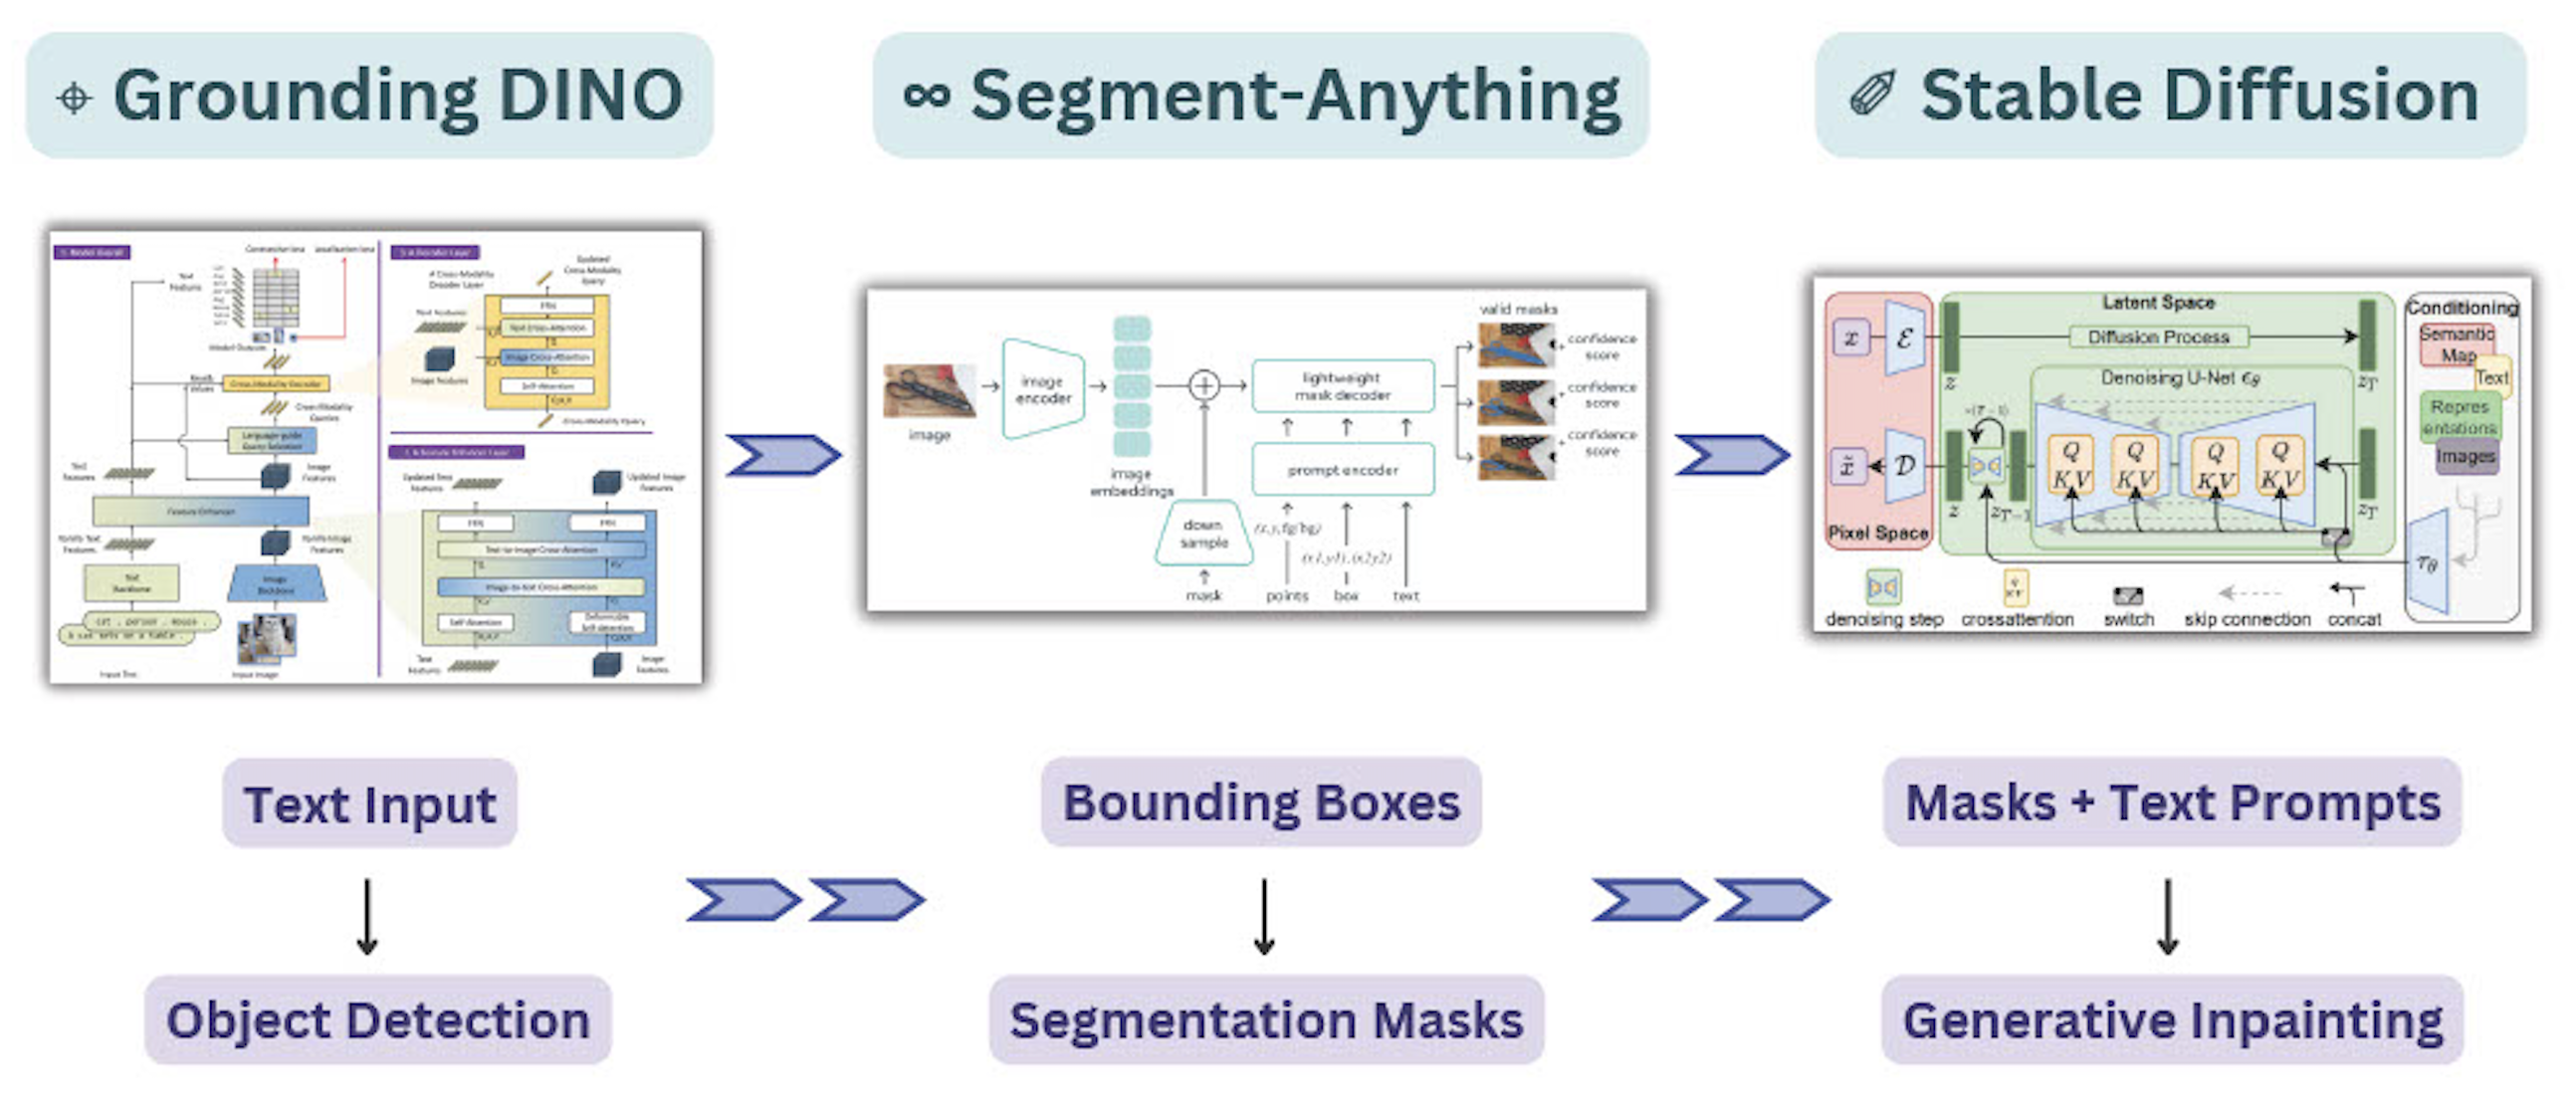

## SAM(Segment Anything)


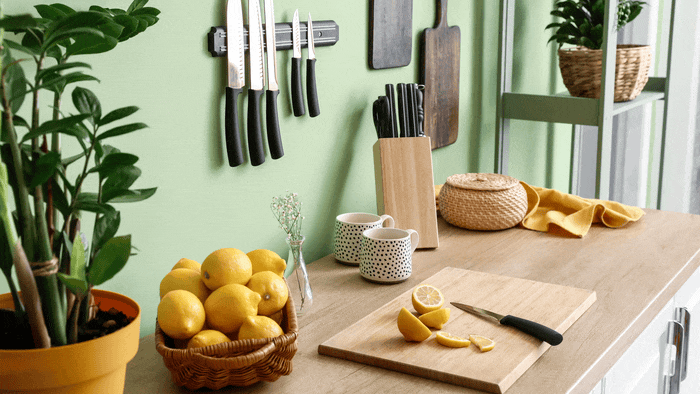

### Installing Dependencies

In [1]:
pwd

'/content'

In [3]:
!pip install transformers diffusers==0.21

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.7 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.21.0-py3-none-any.whl size=1486308 sha256=302af9015c3731a9068dbe9948c34958f8a7d7b96039f9885150dbef3426b16f
  Stored in directory: /root/.cache/pip/wheels/59/90/fd/c35ca194b21484053d9742ee7599042257b033bb48e8a4727b
Successfully built diffusers


In [4]:
pip install segment-anything

In [5]:
pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 3.5 MB/s eta 0:00:00


### importing required libraries

In [8]:
import transformers

In [10]:
import accelerate

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
from typing import List
from PIL import Image
import cv2

import torch
import transformers

from diffusers import StableDiffusionInpaintPipeline
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator

import sys

sys.path.append("..")

HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


### Weights of pretrained Model of Grounding Dino and Segment ANything

In [12]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
%cd {HOME}

!mkdir -p {HOME}/weights
%cd {HOME}/weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

%cd {HOME}
!git clone https://github.com/facebookresearch/segment-anything.git

%cd {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

%cd {HOME}

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 401 (delta 58), reused 50 (delta 50), pack-reused 316
Receiving objects: 100% (401/401), 12.85 MiB | 16.74 MiB/s, done.
Resolving deltas: 100% (204/204), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.8 MB/s eta 0:00:00
/content
/content/weights
/content
Cloning into 'segment-anything'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 295 (delta 117), reused 110 (delta 110), pack-reused 142
Receiving objects: 100% (295/295), 18.30 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (157/157), done.
/content/weights
/content


### making sure it exists

In [ ]:
# Checking if the file exists or not
GROUNDING_DINO_CONFIG_PATH = os.path.join(
    HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
)
print(
    GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH)
)

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(
    HOME, "weights", "groundingdino_swint_ogc.pth"
)
print(
    GROUNDING_DINO_CHECKPOINT_PATH,
    "; exist:",
    os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH),
)

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

In [15]:
# leveraging GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device is: CUDA") if torch.cuda.is_available else print("Device is: CPU")

Device is: CUDA


In [14]:
pwd

'/content'

In [16]:
%cd {HOME}/GroundingDINO
from groundingdino.util.inference import (
    load_model,
    load_image,
    predict,
    annotate,
    Model,
)

/content/GroundingDINO


### Iniatialising grounding dino model

In [17]:
grounding_dino_model = Model(
    model_config_path=GROUNDING_DINO_CONFIG_PATH,
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH,
)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


## Stable Diffusion Pipeline

***  Pipelines provide a simple way to run state-of-the-art diffusion models in inference by bundling all of the necessary components (multiple independently-trained models, schedulers, and processors) into a single end-to-end class  ***

In [46]:
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [47]:
sd_pipe

StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.21.0",
  "_name_or_path": "stabilityai/stable-diffusion-2-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [18]:
sam_chekpoint = SAM_CHECKPOINT_PATH
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_chekpoint)
predictor = SamPredictor(sam)

## Helper Functions

In [37]:
# generating bounding box for the label provided as input
def object_detections(image_path, Text_PROMPT):
  image_bgr = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  # detect objects
  detections, phrases = grounding_dino_model.predict_with_caption(
      image=image_bgr,
      caption=TEXT_PROMPT,
      box_threshold=BOX_THRESHOLD,
      text_threshold=TEXT_THRESHOLD,
  )
  detections.class_id = phrases
  return detections

# for visualization
def plot_images_grid(images, grid_size, title, size, cmap="gray"):
    nrows, ncols = grid_size

    if len(images) > nrows * ncols:
        raise ValueError(
            "The number of images exceeds the grid size. Please increase the grid size or reduce the number of images."
        )

    if nrows == 1 and ncols == 1:
        fig, ax = plt.subplots(figsize=size)
        if images[0].ndim == 2:
            ax.imshow(images[0], cmap)
        else:
            ax.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))

        if titles is not None:
            ax.set_title(titles[0])

        ax.axis("off")
    else:
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=size)

        for idx, ax in enumerate(axes.flat):
            if idx < len(images):
                if images[idx].ndim == 2:
                    ax.imshow(images[idx], cmap=cmap)
                else:
                    ax.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))

                if titles is not None and idx < len(titles):
                    ax.set_title("{}, mask {}".format(titles[idx], idx))

            ax.axis("off")

    plt.show()


# generating segmentation mask
def segment(
    sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray
    ) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(box=box, multimask_output=True)
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)


# generating image
def generate_image(image, mask, prompt, negative_prompt, pipe, seed):
    # resize for inpainting
    w, h = image.size
    in_image = image.resize((512, 512))
    in_mask = mask.resize((512, 512))

    generator = torch.Generator(device).manual_seed(seed)

    result = pipe(
        image=in_image,
        mask_image=in_mask,
        prompt=prompt,
        negative_prompt=negative_prompt,
        generator=generator,
    )
    result = result.images[0]

    return result.resize((w, h))


## Object Detections using Ground Dino

In [26]:
model = load_model(
    "groundingdino/config/GroundingDINO_SwinT_OGC.py",
    "../weights/groundingdino_swint_ogc.pth",
)

BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
TEXT_PROMPT = "fox . background"

MODEL_TYPE = "vit_h"  # default

IMAGE_PATH = "/content/fox.jpg"

IMAGE_NAME = IMAGE_PATH.split("/")[-1]

final text_encoder_type: bert-base-uncased


In [28]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

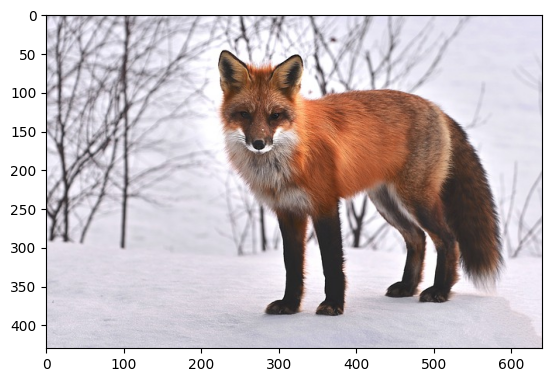

In [31]:
plt.imshow(image_rgb)

In [32]:
# detect objects
detections, phrases = grounding_dino_model.predict_with_caption(
    image=image_bgr,
    caption=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD,
)

detections.class_id = phrases

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [33]:
detections

Detections(xyxy=array([[220.02214 ,  45.368805, 593.9531  , 389.53903 ]], dtype=float32), mask=None, confidence=array([0.8525657], dtype=float32), class_id=['fox'], tracker_id=None)

as can be seen from above, detection contain the bounding box coordinates and class id like fox in this case.it will be sent to segmentation model for generating mask

## Generating Masks of detected object using SEGMENT ANYTHING Model

In [34]:
# Instantiate SAM model
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH).to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

sam_predictor = SamPredictor(sam)

In [35]:
# convert bbox detections to masks and add to detections object
detections.mask = segment(
    sam_predictor=sam_predictor, image=image_bgr, xyxy=detections.xyxy
)

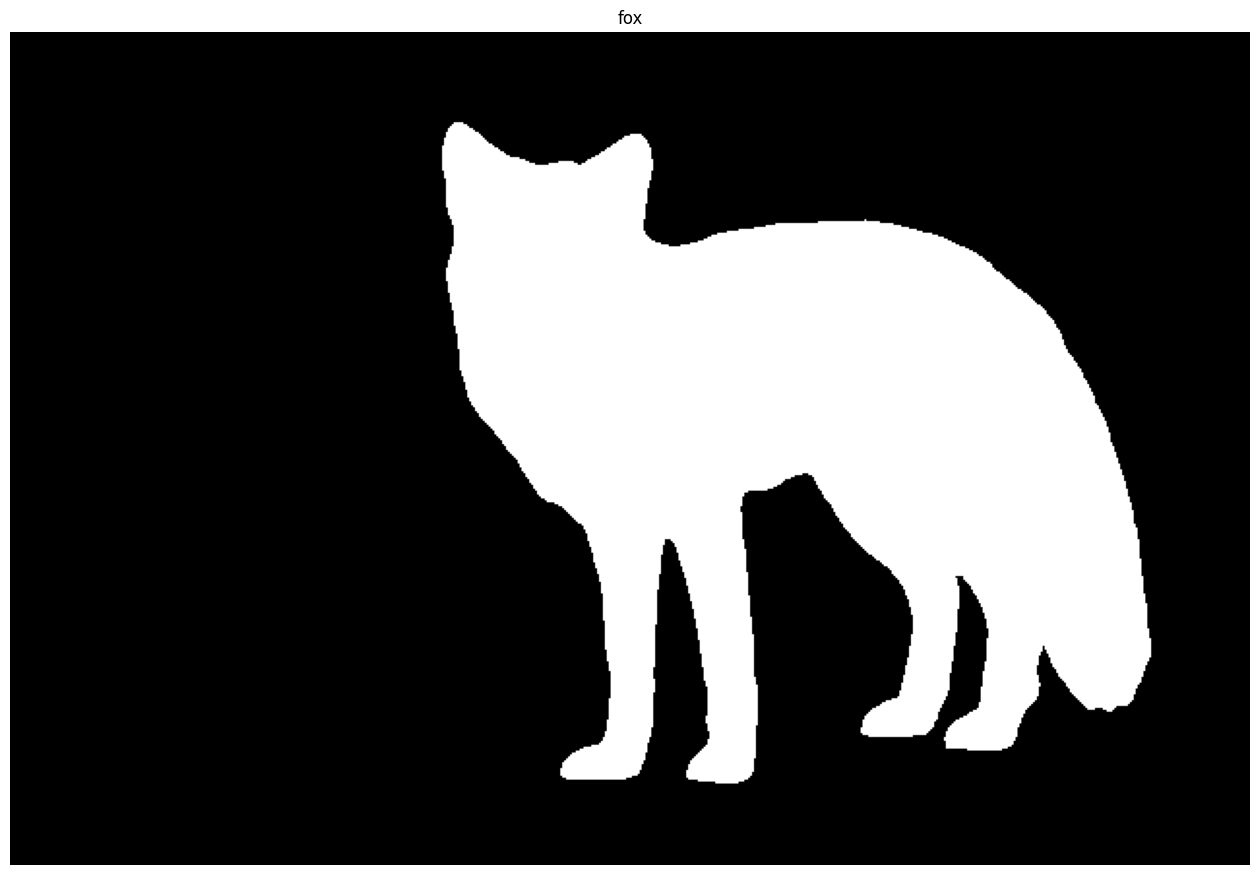

In [61]:
grid_size_dimension = math.ceil(math.sqrt(len(detections.mask)))

titles = [class_id for class_id in detections.class_id]

plot_images_grid(
    images=(detections.mask),
    title=["x" for i in range(len(detections.mask))],
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(16, 16),
)

# Image Generation using Stable Diffusion

#### Inpainting

Image inpainting refers to the process of filling-in missing data in a designated region of an image. Originally, image inpainting was used to restore damaged regions of a photo to look more like the original, but is now commonly used with masks to intentionally alter regions of an image.

In [41]:
fox = detections.mask[0]

In [42]:
image_source_pil = Image.fromarray(image_rgb)
image_mask_pil = Image.fromarray(fox)

In [43]:
image_mask_pil = Image.fromarray((fox * 255).astype(np.uint8))

  0%|          | 0/50 [00:00<?, ?it/s]

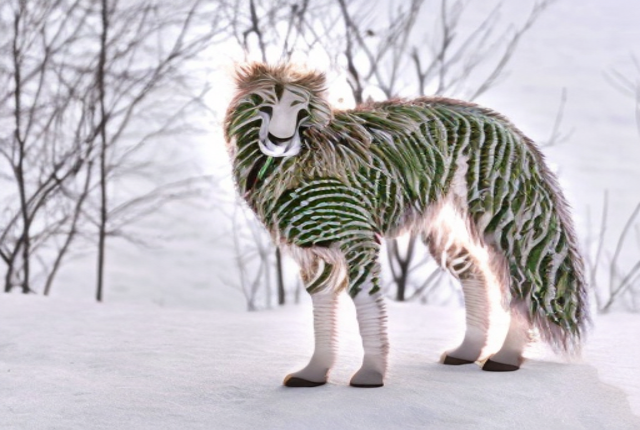

In [50]:
ip_prompt = "green"
ip_negative_prompt = "low resolution, ugly"
ip_SEED = 55
generated_image = generate_image(
    image=image_source_pil,
    mask=image_mask_pil,
    prompt=ip_prompt,
    negative_prompt=ip_negative_prompt,
    pipe=sd_pipe,
    seed=ip_SEED,
)
generated_image

#For Background

#### Outpainting

Image outpainting is the process of using generative AI to extend images beyond their original borders, thereby generating parts of the image that didn’t exist before. We’ll effectively do this by masking the original background and using the same Stable Diffusion Inpainting Pipeline.

In [70]:
detections.mask

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

for our use case we will be using false part for generating background or by using tilde before the detected object

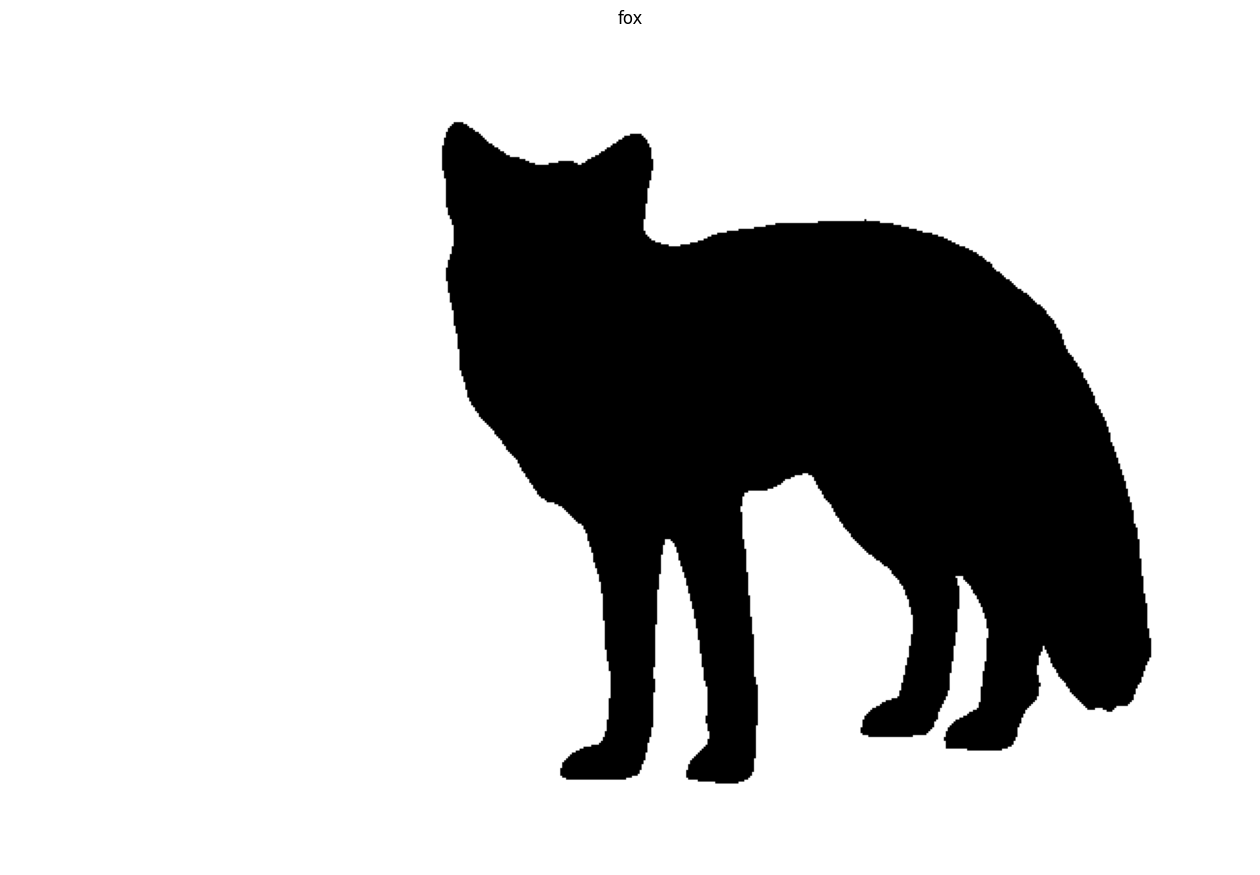

In [60]:
grid_size_dimension = math.ceil(math.sqrt(len(detections.mask)))

titles = [class_id for class_id in detections.class_id]

plot_images_grid(
    images=(detections.mask==False), #by keeping false we can visualize the backgroound is assigned as 1
    title=["x" for i in range(len(detections.mask))],
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(16, 16),
)

In [78]:
image_source_pil = Image.fromarray(image_rgb)
image_mask_pil = Image.fromarray(fox==False)

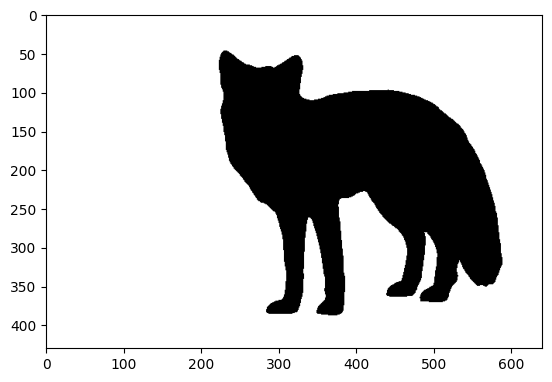

In [79]:
plt.imshow(image_mask_pil)

In [84]:
# the mask contain 0 and 1 but we need to have value from (0,255) so we will multiply by 255 here and keeping fox==False work for generating background
image_mask_pil = Image.fromarray(((fox==False) * 255).astype(np.uint8))

  0%|          | 0/50 [00:00<?, ?it/s]

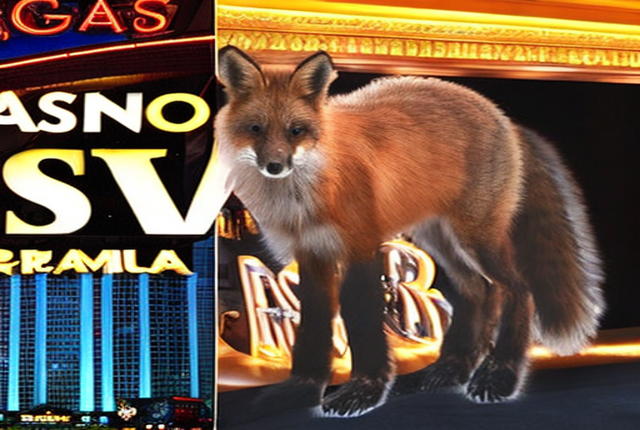

In [85]:
op_prompt = "casino Las Vegas"
op_negative_prompt = "low resolution, ugly"
op_SEED = 234908243
generated_image = generate_image(
    image=image_source_pil,
    mask=image_mask_pil,
    prompt=op_prompt,
    negative_prompt=op_negative_prompt,
    pipe=sd_pipe,
    seed=op_SEED,
)
generated_image

  0%|          | 0/50 [00:00<?, ?it/s]

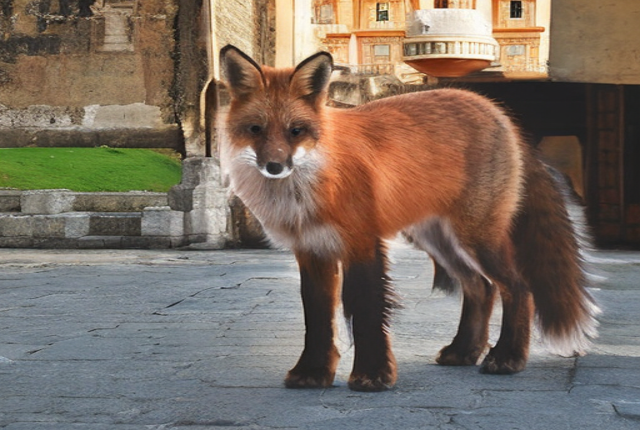

In [86]:
op_prompt = "near a palace"
op_negative_prompt = "low resolution, ugly"
op_SEED = 234908243
generated_image = generate_image(
    image=image_source_pil,
    mask=image_mask_pil,
    prompt=op_prompt,
    negative_prompt=op_negative_prompt,
    pipe=sd_pipe,
    seed=op_SEED,
)
generated_image

  0%|          | 0/50 [00:00<?, ?it/s]

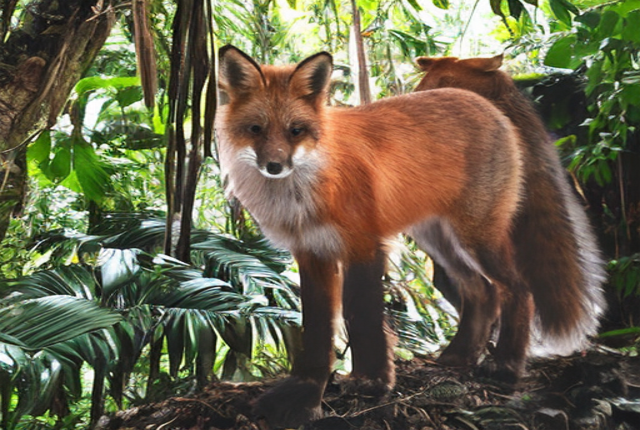

In [87]:
op_prompt = "in jungle"
op_negative_prompt = "low resolution, ugly"
op_SEED = 234908243
generated_image = generate_image(
    image=image_source_pil,
    mask=image_mask_pil,
    prompt=op_prompt,
    negative_prompt=op_negative_prompt,
    pipe=sd_pipe,
    seed=op_SEED,
)
generated_image

# Ignore the following,.. I am trying to built app by using the simplified pipepline

## Final Pipeline

In [ ]:
#input
input_image_path = " "
object_to_detect_prompt = ' '

In [ ]:
detections = object_detection(input_image_path, object_to_detect_prompt)

In [ ]:
segmentation = segment(sam_predictor=sam_predictor, image=image_bgr, xyxy=detections.xyxy)

In [ ]:
# prompt for generating required output
generate_prompt = " "

In [ ]:
imnage_generated = generated_image = generate_image(
    image=image_source_pil,
    mask=image_mask_pil,
    prompt=op_prompt,
    negative_prompt=op_negative_prompt,
    pipe=sd_pipe,
    seed=op_SEED,
)